In [1]:
import os
import sys
import numpy as np
import scipy as sp
import pandas as pd
import cv2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation
import pickle
import re
import csv
import math
import random
import time
import datetime
import copy


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import gymnasium as gym

from collections import namedtuple
from collections import deque
from itertools import count

import glob
import io
import base64
import IPython

import pygame
import moviepy

from utils import plot_rewards

from typing import Optional
%matplotlib inline
plt.ion()


## Part 1 Environment setup

In [2]:
env = gym.make('MountainCar-v0', render_mode='rgb_array')

In [3]:
state, info = env.reset()
state, info

(array([-0.44719252,  0.        ], dtype=float32), {})

In [4]:
img = env.render()
state_text_01 = f"Position: {state[0]:.2f}\n"
state_text_01 += f"Velocity: {state[1]:.2f}"
state_text_02 = f"Step = 0"

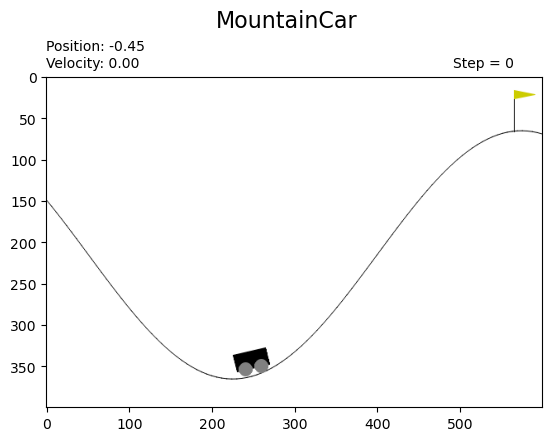

In [5]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.suptitle("MountainCar", fontsize=16)
plt.imshow(img)
plt.text(0, 1.03, state_text_01, fontsize=10, transform=ax.transAxes)
plt.text(0.82, 1.03, state_text_02, fontsize=10, transform=ax.transAxes)
plt.show()

## Part 2 Random Agent

In [6]:
class RandomAgent:
    def __init__(self, action_space):
        self.action_space = action_space

    def observe(self, state, action, next_state, reward):
        # RandomAgent does not learn from observations
        pass

    def select_action(self, state):
        return self.action_space.sample()

    def update(self):
        # RandomAgent does not update any parameters
        pass

def run_random_agent(env, agent, episodes=100):
    episode_durations = []

    for episode in range(episodes):
        state, _ = env.reset()
        done = False
        truncated = False
        t = 0

        while not done and not truncated:
            action = agent.select_action(state)
            next_state, reward, done, truncated, info = env.step(action)
            agent.observe(state, action, next_state, reward)
            state = next_state
            t += 1

        episode_durations.append(t)

    return episode_durations


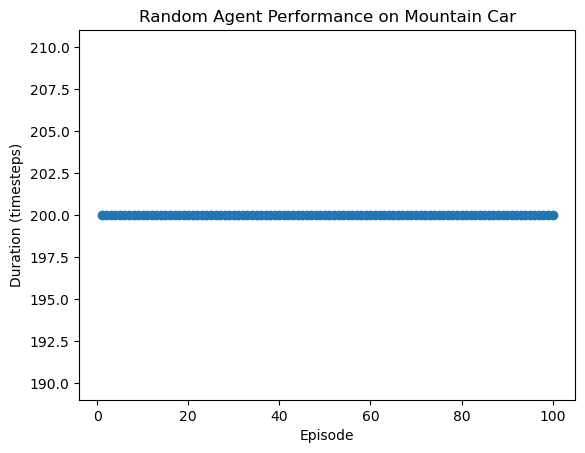

In [7]:
# Create the environment
env = gym.make('MountainCar-v0')
agent = RandomAgent(env.action_space)

# Run the agent for 100 episodes
episode_durations = run_random_agent(env, agent, episodes=100)

# Plot the duration of each episode
plt.scatter(range(1, 101), episode_durations)
plt.xlabel('Episode')
plt.ylabel('Duration (timesteps)')
plt.title('Random Agent Performance on Mountain Car')
plt.show()


## Part 2 DQN

In [6]:
class MLP(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
Transition = namedtuple('Transition', ('state', 'action', 'reward','next_state'))
class ReplayBuffer:
    def __init__(self, capacity: int):
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)
    
    def push(self, *args):
        self.memory.append(Transition(*args))
    
    def sample(self, batch_size: int):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [10]:
class DQNAgent:
    def __init__(self, policy_net, target_net, action_dim, gamma, epsilon_start, epsilon_end, epsilon_decay, buffer, batch_size, lr,device, optimizer, tau):
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.steps_done = 0
        self.device = device
        self.tau = tau
        
        self.Q = policy_net
        self.target_Q = target_net
        self.target_Q.load_state_dict(self.Q.state_dict())
        self.target_Q.eval()
        
        self.optimizer = optimizer(self.Q.parameters(), lr=lr, amsgrad=True)
        self.replay_buffer = buffer
    
    def observe(self, state, action, reward, next_state):
        self.replay_buffer.push(state, action, reward, next_state)
    
    def select_action(self, state):
        sample = random.random()
        eps_threshold = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * math.exp(-1. * self.steps_done / self.epsilon_decay)
        self.steps_done += 1

        if sample > eps_threshold:
            with torch.no_grad():
                q_values = self.Q(state)
                action = q_values.argmax().item()
                # print(f"Policy net result: {q_values}, action: {action}")
        else:
            action = random.choice(range(self.action_dim))
        return action, eps_threshold
    
    def update(self):
        if len(self.replay_buffer) < self.batch_size:
            return
        
        transitions = self.replay_buffer.sample(self.batch_size)
        batch = Transition(*zip(*transitions))

        state_batch = torch.stack(batch.state)
        action_batch = torch.stack(batch.action)
        reward_batch = torch.tensor(batch.reward, device=self.device)


        # get Q values from policy network
        q_values = self.Q(state_batch).gather(1, action_batch)
        next_state_values = torch.zeros(self.batch_size, device=self.device)

        # get Q values from target network
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=self.device, dtype=torch.bool)
        non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_Q(non_final_next_states).max(1)[0]
        expected_q_values = reward_batch + self.gamma * next_state_values
        # print("mean expected Q values: ", expected_q_values.mean())
        
        criterion = nn.SmoothL1Loss()
        # print(f"expected Q values: {expected_q_values}")
        loss = criterion(q_values, expected_q_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        
        torch.nn.utils.clip_grad_value_(self.Q.parameters(), 1000)
        self.optimizer.step()

        # update target network
        target_net_dict = self.target_Q.state_dict()
        policy_net_dict = self.Q.state_dict()
        for key in target_net_dict:
            target_net_dict[key] = self.tau * policy_net_dict[key] + (1 - self.tau) * target_net_dict[key]
        self.target_Q.load_state_dict(target_net_dict)
  


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
hidden_dim = 128
buffer_capacity = 10000
policy_net = MLP(state_dim, action_dim, hidden_dim).to(device)
target_net = MLP(state_dim, action_dim, hidden_dim).to(device)
buffer = ReplayBuffer(buffer_capacity)


gamma = 0.99
epsilon_start = 0.9
epsilon_end = 0.05
epsilon_decay = 500

batch_size = 128
lr = 1e-04
tau = 0.005 # Target Network: Update Rate

In [12]:
def energy(state) :
    x = state[0]
    v = state[1]
    m = 1.0
    g = 0.0025
    h = np.sin((x - (0.5 * np.pi)) + 0.5) + 1.0
    u = m * g * h
    k = 0.5 * v * v
    xmax = 0.6
    vmax = 0.07
    n = 1 / ((m * g * (np.sin((xmax - (0.5 * np.pi)) + 0.5) + 1.0)) + (0.5 * vmax * vmax))
    e = n * (u + k)
    return e

In [13]:
episode_rewards = []
episode_steps = []
num_episodes = 1000

agent = DQNAgent(policy_net, target_net, action_dim, gamma, epsilon_start, epsilon_end, epsilon_decay, buffer, batch_size, lr, device, optimizer, tau)

for episode in range(num_episodes):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device)
    done = False
    total_reward = 0
    steps = 0
    
    while not done:
        # get action, reward, next_state, done from env
        action, eps_threshold = agent.select_action(state)
        next_state, reward, terminated, truncated, info = env.step(action)

        mod_reward = True
        if mod_reward :
            reward = (reward * 0.01) + (energy(next_state) - energy(state.cpu().numpy()))
            if next_state[0] >= 0.5 :
                reward = reward + 1.0
            else :
                reward = reward


        done = terminated or truncated
        total_reward += reward
        steps += 1

        # change to tensor
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(next_state, dtype=torch.float32, device=device)
        reward = torch.tensor([reward], dtype=torch.float32, device=device)
        action = torch.tensor([action], dtype=torch.long, device=device)

        # observe and update agent
        agent.observe(state, action, reward, next_state)
        state = next_state

        agent.update()
    
    print(f'Episode {episode + 1}, Reward: {total_reward}, Steps: {steps}, Epsilon: {eps_threshold:.2f}')
    episode_rewards.append(total_reward)
    episode_steps.append(steps)
    
    # Plot rewards every 10 episodes
    if episode % 10 == 0:
        plot_rewards(episode_rewards, episode_steps, realtime=True)

# plot_rewards(episode_rewards, episode_steps, realtime=False)
print('Training complete')
time.sleep(2)
env.close()

plot_rewards(episode_rewards, episode_steps, realtime=False)

Episode 2, Reward: -1.9947012967875768, Steps: 200, Epsilon: 0.43
Episode 3, Reward: -1.9572075120672596, Steps: 200, Epsilon: 0.31
Episode 4, Reward: -1.7979304626183215, Steps: 200, Epsilon: 0.22
Episode 5, Reward: -0.37294628858876, Steps: 185, Epsilon: 0.17
Episode 6, Reward: -0.058889409499777834, Steps: 160, Epsilon: 0.14


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

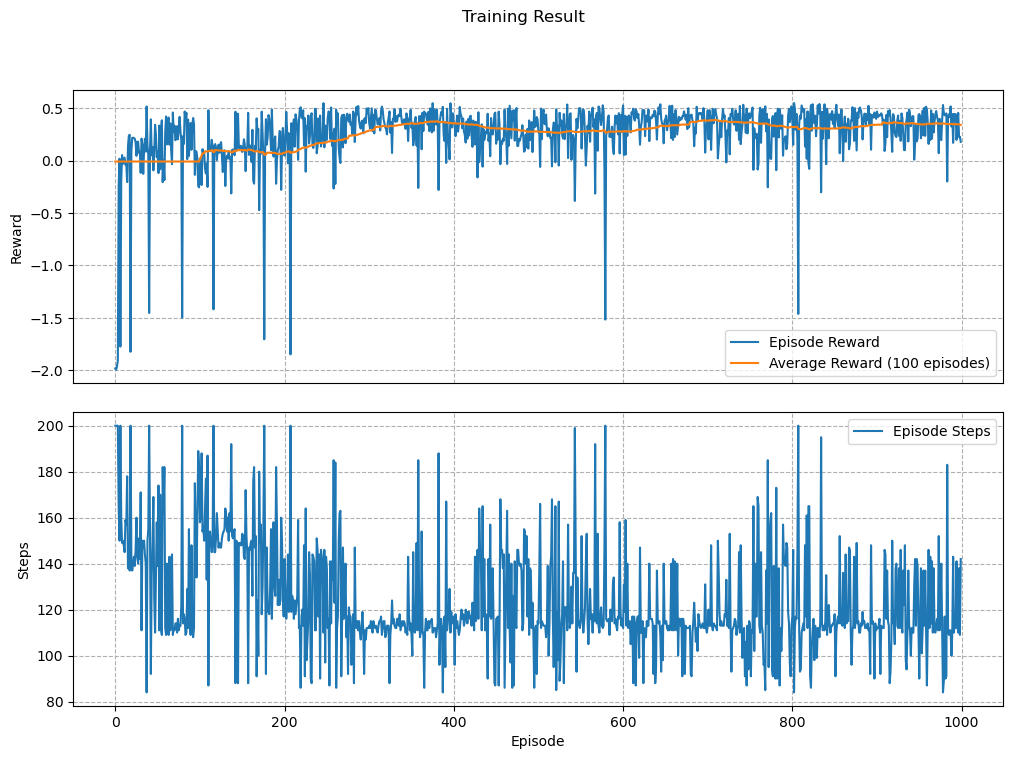

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [16]:
plot_rewards(episode_rewards, episode_steps, realtime=False)

In [17]:
# save the model
torch.save(policy_net.state_dict(), 'dqn_policy_net.pickle')

# RND reward

https://github.com/orrivlin/MountainCar_DQN_RND/tree/master

In [8]:
class DQN_RND:
    def __init__(self, gamma, policy_net, target_net, rnd_target_net, rnd_predictor_net, action_dim, epsilon_start, epsilon_end, epsilon_decay, buffer, batch_size, lr,device, optimizer, tau):
        self.device = device
        self.action_dim = action_dim

        self.gamma = gamma
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.steps_done = 0
        self.tau = tau    # update rate for target network
        
        self.policy_net = policy_net
        self.target_net = target_net
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.rnd_target_net = rnd_target_net
        self.rnd_predictor_net = rnd_predictor_net
        self.rnd_target_net.eval()
        
        self.optimizer = optimizer(self.policy_net.parameters(), lr=lr, amsgrad=True)
        self.rnd_optimizer = optimizer(self.rnd_predictor_net.parameters(), lr=lr, amsgrad=True)
        self.replay_buffer = buffer

        for param in self.rnd_predictor_net.parameters():
            assert param.requires_grad, "rnd_predictor_net parameter does not require grad"

    

    def observe(self, state, action, reward, next_state):
        self.replay_buffer.push(state, action, reward, next_state)

    def select_action(self, state):
        sample = random.random()
        eps_threshold = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * math.exp(-1. * self.steps_done / self.epsilon_decay)
        self.steps_done += 1

        if sample > eps_threshold:
            with torch.no_grad():
                q_values = self.policy_net(state)
                action = q_values.argmax().item()
        else:
            action = random.choice(range(self.action_dim))
        return action, eps_threshold


    def compute_rnd_reward(self, state):

        with torch.no_grad():
            rnd_target = self.rnd_target_net(state)
        rnd_prediction = self.rnd_predictor_net(state)
        rnd_reward = (rnd_target - rnd_prediction).pow(2).sum()
        
        return rnd_reward


    def update(self):
        if len(self.replay_buffer) < self.batch_size:
            return
        
        transitions = self.replay_buffer.sample(self.batch_size)
        batch = Transition(*zip(*transitions))

        state_batch = torch.stack(batch.state).to(self.device)
        action_batch = torch.stack(batch.action).to(self.device)
        reward_batch = torch.tensor(batch.reward, device=self.device)

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=self.device, dtype=torch.bool)
        non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])

        # get Q values from policy network
        q_values = self.policy_net(state_batch).gather(1, action_batch)
        next_state_values = torch.zeros(self.batch_size, device=self.device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]
        expected_q_values = reward_batch + self.gamma * next_state_values

        criterion = nn.SmoothL1Loss()
        loss = criterion(q_values, expected_q_values.unsqueeze(1))

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 1000)
        self.optimizer.step()

        # update target network
        target_net_dict = self.target_net.state_dict()
        policy_net_dict = self.policy_net.state_dict()
        for key in target_net_dict:
            target_net_dict[key] = self.tau * policy_net_dict[key] + (1 - self.tau) * target_net_dict[key]
        self.target_net.load_state_dict(target_net_dict)


        # Update RND predictor network
        self.rnd_optimizer.zero_grad()
        rnd_target_values = self.rnd_target_net(state_batch)
        rnd_prediction_values = self.rnd_predictor_net(state_batch)
        rnd_loss = (rnd_target_values - rnd_prediction_values).pow(2).sum()
        rnd_loss.backward()
        self.rnd_optimizer.step()

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
hidden_dim = 128
buffer_capacity = 10000
policy_net = MLP(state_dim, action_dim, hidden_dim).to(device)
target_net = MLP(state_dim, action_dim, hidden_dim).to(device)
rnd_target_net = MLP(state_dim, 1, hidden_dim).to(device)
rnd_predictor_net = MLP(state_dim, 1, hidden_dim).to(device)
buffer = ReplayBuffer(buffer_capacity)


gamma = 0.99
epsilon_start = 0.9
epsilon_end = 0.05
epsilon_decay = 200

batch_size = 128
lr = 1e-04
tau = 0.005 # Target Network: Update Rate

In [13]:
episode_rewards = []
episode_steps = []
num_episodes = 1000

agent = DQN_RND(gamma, policy_net, target_net, rnd_target_net, rnd_predictor_net, action_dim, epsilon_start, epsilon_end, epsilon_decay, buffer, batch_size, lr, device, optimizer, tau)

for episode in range(num_episodes):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device)
    done = False
    total_reward = 0
    steps = 0
    
    while not done:
        action, eps_threshold = agent.select_action(state)
        next_state, reward, terminated, truncated, info = env.step(action)

        mod_reward = True
        if mod_reward :
            rnd_reward = agent.compute_rnd_reward(torch.tensor(next_state, dtype=torch.float32, device=device))
            reward = reward * 0.01 + rnd_reward.item() * 10

        done = terminated or truncated
        total_reward += reward
        steps += 1

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(next_state, dtype=torch.float32, device=device)
        reward = torch.tensor([reward], dtype=torch.float32, device=device)
        action = torch.tensor([action], dtype=torch.long, device=device)

        agent.observe(state, action, reward, next_state)
        state = next_state

        agent.update()
    
    print(f'Episode {episode + 1}, Reward: {total_reward}, Steps: {steps}, Epsilon: {eps_threshold:.2f}')
    episode_rewards.append(total_reward)
    episode_steps.append(steps)
    
    if episode % 10 == 0:
        plot_rewards(episode_rewards, episode_steps, realtime=True)

print('Training complete')
env
plot_rewards(episode_rewards, episode_steps, realtime=False)

Episode 92, Reward: -1.9999997002276564, Steps: 200, Epsilon: 0.05
Episode 93, Reward: -1.999999675036688, Steps: 200, Epsilon: 0.05
Episode 94, Reward: -1.9999997712803532, Steps: 200, Epsilon: 0.05
Episode 95, Reward: -1.999999793813903, Steps: 200, Epsilon: 0.05


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>